First, we import the needed libraries: cv2 for image editing, numpy for randomized operations, since we'll be using a lot of different configurations and urllib.request to download the files of e-class.

In [0]:
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow #Colab magic to show image
import os #Acually not needed

Entering the two images' URLs, as found in e-class and reuploaded to github.

In [0]:
image_1 = "https://github.com/NKalavros/image_processing_ex1/blob/master/image_1.jpg?raw=true"
image_2 = "https://github.com/NKalavros/image_processing_ex1/blob/master/image_2.jpg?raw=true"

Downloading the two images into the working directory and naming them image_1 and image_2 respectively.

In [3]:
urllib.request.urlretrieve(image_1,"image_1.jpg")
urllib.request.urlretrieve(image_2,"image_2.jpg")

('image_2.jpg', <http.client.HTTPMessage at 0x7f4864f8ca90>)

Now we can load the images as numpy arrays in grayscale and perform some visual inspection. We should also normalize them by dividing by 255.

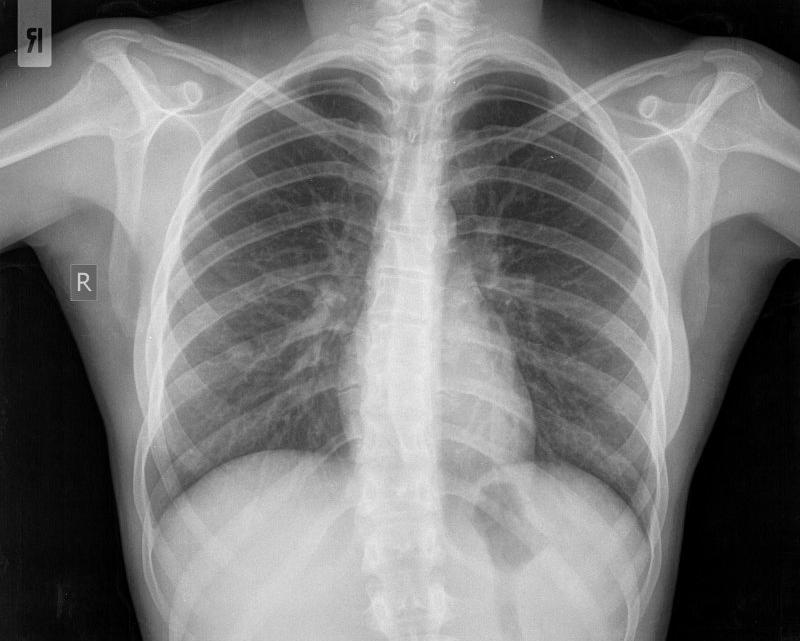

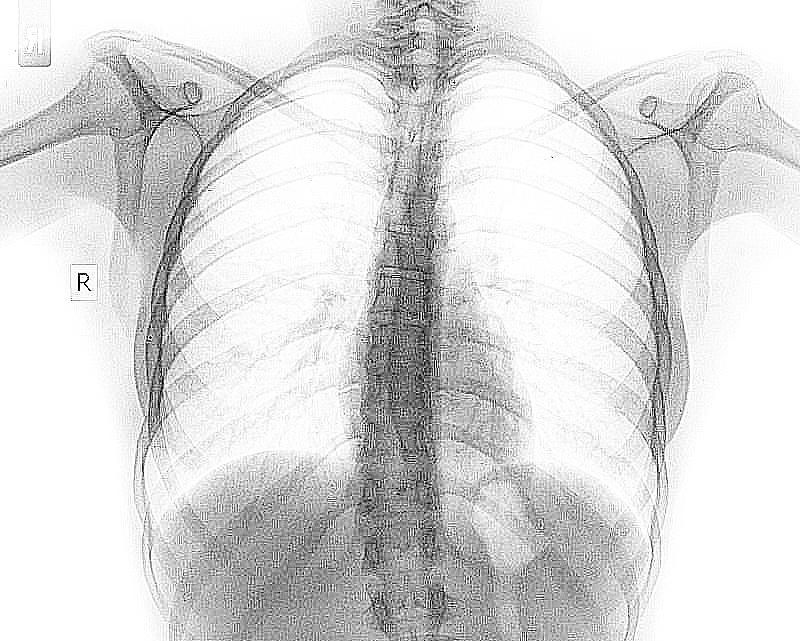

In [4]:
image_1 = cv2.imread("image_1.jpg",cv2.IMREAD_UNCHANGED)
image_2 = cv2.imread("image_2.jpg",cv2.IMREAD_UNCHANGED)
cv2_imshow(image_1)
cv2_imshow(image_2)
image_1 = image_1 / 255
image_2 = image_2 / 255

A visual inspection of the two different images as well as the tips gracefully left in the exercise point to the direction of what kind of processing techniques should be employed to create image_2 from image_1. First, we need a way to define distance between images. For the purpose of this exercise, subtracting pixel-wise and taking the norm of the matrix should suffice.

In [0]:
def image_diff(img_1,img_2=image_2):
    diff = img_1 - img_2
    return(np.linalg.norm(diff))

In [6]:
print(image_diff(image_1,image_2))

409.72356737305194


Now, we seek to minimize this difference. In this notebook, a totally blind approach is followed, using a genetic algorithm. At each step, a choice is made for a filtering operation. Those include addition (multiples of 20/255), multiplication (multiples of (255+k*20)/255)), competents (very likely), gamma adjustment and some famous filters like mean, median, sobel, laplace. 

Let's consider a step k of this process. Starting from m images, in step k, we apply n different techniques to obtain at most m*n images (breeding). Then we keep only the ones that pass a specific criterion (e.g. distance between images lowering, bound). If after filtering by the criterion, the images are more than M, we keep the M best ones (culling). This has the inherent assumption that the true transformation can be discovered in a step-wise manner and that the true transformation steps exist (or at least a transformation close in terms to them) exist within the defined combinatorial space.

There are 26 filters for addition (and so 26 for subtraction), 12 for multiplication, 1 for competent, 14 for gamma correction, 1 for histogram equalization. After some editing and consulting code of a fellow student, one was added for unsharpening (8 more). After further deliberation, Sobel filtering was added (2 more, x and y).

At each step, 91 new images are created and only the ones that have lower distance to image_2 than the original ones at this step are kept. We set M to 10 (in the interest of time) and employ a trace list to keep track of the transformations that lead to the best results. The criterion by which to keep an image is the reduction in the distance with the target image. Finally, this genetic algorithm is elitist, which means it keeps only the top M contenders and allows them to breed (no probability of breeding is assigned, it is binary).

In the next cell, all operations are defined (Sobel and Unsharp can also be implemented as functions, which would be better and result in cleaner code).

In [7]:
#Added rounding to avoid overflows
adding = np.round(np.arange(1,255,10)/255,3) #Random numbers
multiplying = np.round(np.arange(0,0.6,0.05) + 1.01,3) #Must not include 1, as it makes it an infinite loop
gammas = np.arange(1,4.5,0.25) #Random numbers
def competent(image_1):
    """Function that calculates the competent of an image"""
    return(1 - image_1)
def adjust_gamma(image, gamma=1.0,floating = True):
    """Simple function for gamma correction"""
    invGamma = 1.0 / gamma #Invert gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8") #Create the lookup table
    if floating == True:
        return cv2.LUT(image*255, table) #Map it to the image (multiplied to the 255 scale)
    else:
        return(cv2.LUT(image,table))
unsharp = np.arange(1.4,2.1,0.1)
print(len(adding),len(adding),len(multiplying),len(gammas),1,1,len(unsharp),1,1) #Number of filters
ops = {"add":["add_" + str(round(x,3)) for x in adding],
       "sub":["sub_" + str(round(x,3)) for x in adding],
       "mul":["mult_" + str(round(x,3)) for x in multiplying],
       "gam":["gamma_" + str(x) for x in gammas],
       "com":["comp"],
       "eqh":["eqhis"],
       "uns":["uns_" + str(x) + "_" + str(-x + 1) for x in unsharp],
       "sox":["sobelx"],
       "soy":["sobely"]}
print(ops)

26 26 12 14 1 1 8 1 1
{'add': ['add_0.004', 'add_0.043', 'add_0.082', 'add_0.122', 'add_0.161', 'add_0.2', 'add_0.239', 'add_0.278', 'add_0.318', 'add_0.357', 'add_0.396', 'add_0.435', 'add_0.475', 'add_0.514', 'add_0.553', 'add_0.592', 'add_0.631', 'add_0.671', 'add_0.71', 'add_0.749', 'add_0.788', 'add_0.827', 'add_0.867', 'add_0.906', 'add_0.945', 'add_0.984'], 'sub': ['sub_0.004', 'sub_0.043', 'sub_0.082', 'sub_0.122', 'sub_0.161', 'sub_0.2', 'sub_0.239', 'sub_0.278', 'sub_0.318', 'sub_0.357', 'sub_0.396', 'sub_0.435', 'sub_0.475', 'sub_0.514', 'sub_0.553', 'sub_0.592', 'sub_0.631', 'sub_0.671', 'sub_0.71', 'sub_0.749', 'sub_0.788', 'sub_0.827', 'sub_0.867', 'sub_0.906', 'sub_0.945', 'sub_0.984'], 'mul': ['mult_1.01', 'mult_1.06', 'mult_1.11', 'mult_1.16', 'mult_1.21', 'mult_1.26', 'mult_1.31', 'mult_1.36', 'mult_1.41', 'mult_1.46', 'mult_1.51', 'mult_1.56'], 'gam': ['gamma_1.0', 'gamma_1.25', 'gamma_1.5', 'gamma_1.75', 'gamma_2.0', 'gamma_2.25', 'gamma_2.5', 'gamma_2.75', 'gamma_3

In [0]:
def gen_algo_image_mods(image_1, result=image_2,M = 10,bookkeeping = ops):
    generation = [] #The first generation initialized with an empty list
    generation.append(image_1) #Adding the first image 
    generation = np.array(generation) #Turn it into a [1,x,y] array
    counter = 0 #counting
    new_gen = np.zeros((1,image_1.shape[0],image_1.shape[1])) #Empty array for size compliance
    new_bookkeep = [""] #Initialize with empty string (only op we've done yet technically)
    n_ops = sum(map(len,ops.values())) #Number of operation
    while True: #Until break
        best_dist = np.min(np.linalg.norm(generation - np.expand_dims(result,0),axis = (1,2)),axis = 0) #Get the best distance, epxand dims of image_2 to [1,x,y] tovectorize the calculation
        print("Beginning generation {}. Best distance is: {}. The shape of the generation matrix is {}.".format(counter,best_dist,generation.shape)) #Diagnostic
        for i in range(generation.shape[0]): #Could vectorize this, but the code gets fairly complex afterwards. Loop over all images
            #With some better code, instead of repeatedly adjusting new_gen and offset, this can be turned into another loop. Also, a new array could be made, as its shape can be precomputed and populated, instead of utilizing vstack, which is very slow.
            offset = 0 #In order to keep the bookkeeping in a string array, an offset will have to be used
            new_gen = np.vstack((new_gen,[generation[i,:,:] + x for x in adding])) #List comprehension to add in all d of the images (array of shape [d,x,y]) x_add in their x and y
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['add']] + new_bookkeep[i*n_ops + offset:] #Insert the operation everywhere
            offset = offset + len(bookkeeping['add']) #Set new offset                                    
            new_gen = np.vstack((new_gen,[generation[i,:,:] - x for x in adding])) #Same with subtraction
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['sub']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['sub'])
            new_gen = np.vstack((new_gen,[generation[i,:,:]*x for x in multiplying])) #Same with multiplication
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['mul']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['mul'])
            new_gen = np.vstack((new_gen,np.expand_dims(competent(generation[i,:,:]),0))) #Same with the competent, expand dims is there for shape compliance
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['com']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['com'])
            new_gen = np.vstack((new_gen,np.expand_dims(cv2.equalizeHist(np.array(generation[i,:,:]*255,dtype=np.uint8))/255,0))) #Convert to uint8 and back for cv2 compliance
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['eqh']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['eqh'])
            for j in gammas: #Easily vectorizable over the gammas with another apply_along_axis. An interesting one liner to make work
                new_gen = np.vstack((new_gen,np.expand_dims(adjust_gamma(np.array(generation[i,:,:]*255,dtype=np.uint8),j)/255,0))) #Hacks for uint or float64 compliance in numpy, otherwise just using the loop value
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['gam']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['gam'])
            for j in range(len(unsharp)): #Vectorizable over unsharp. Should write a function and implement it at some point
                gaussian_3 = cv2.GaussianBlur(np.array(generation[i,:,:]*255,dtype=np.uint8), (9,9), 10.0)/255 #apply the Gaussian Blur
                unsharp_image = cv2.addWeighted(generation[i,:,:], unsharp[j], gaussian_3, -1*unsharp[j]+1, 0, generation[i,:,:]) #Unsharpened image
                new_gen = np.vstack((new_gen,np.expand_dims(unsharp_image,0)))
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['uns']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['uns'])
            new_gen = np.vstack((new_gen,np.expand_dims(cv2.Sobel(np.array(generation[i,:,:]*255,dtype=np.uint8),cv2.CV_64F,0,1,5)/255,0)))
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['sox']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['sox'])
            new_gen = np.vstack((new_gen,np.expand_dims(cv2.Sobel(np.array(generation[i,:,:]*255,dtype=np.uint8),cv2.CV_64F,0,1,5)/255,0)))
            new_bookkeep = new_bookkeep[0:i*n_ops + offset] + [new_bookkeep[i*n_ops + offset] + "|" + x for x in bookkeeping['soy']] + new_bookkeep[i*n_ops + offset:] #Insert the operation again
            offset = offset + len(bookkeeping['soy'])
            del new_bookkeep[i*n_ops + offset] #Remove the last object (the one that had no operation applied)     
            print("Image {} complete".format(i))  
        print("Created {} new images. Calculating distances...".format(new_gen.shape[0])) #Diagnostic
        dists = np.linalg.norm((new_gen - np.expand_dims(result,0)),axis = (1,2)) #Same with the above code, without getting the minimum
        keep = dists <= best_dist #Mask to keep images
        print("Keeping {} new images after filtering with the distance criterion".format(np.sum(keep))) #Diagnostic
        if np.sum(keep) == 0: #If done, break
            print("No better images found. Ending...") #Diagnostic
            break #Actual break
        new_gen = new_gen[keep,:,:] #Apply mask
        new_bookkeep = list(np.array(new_bookkeep)[keep[1:]]) #Apply to the bookkeeping too! Need to jump over some hoops to achieve it though (Conversion to numpy and back). Also deleting the empty keep
        generation = new_gen #Set as new generation
        if generation.shape[0] > M: #Keep at a minimum for set worst case memory and time complexity per round
            print("Too many images, selecting the top {}".format(M)) #Diagnostic
            dists = np.linalg.norm((generation - np.expand_dims(result,0)),axis=(1,2)) #Calculate distances
            generation = generation[np.argsort(dists,axis = 0),:,:] #Rank them and use them to sort generation's results
            generation = generation[0:M,:,:] #Keep top M
            new_bookkeep = list(np.array(new_bookkeep)[np.argsort(dists,axis=0)]) #Keep only the best ones. Converting to numpy and back here too
            new_bookkeep = new_bookkeep[0:M] #Keep only the best ones
        print(new_bookkeep)
        counter = counter + 1 #Increment
        new_gen = np.empty((1,image_1.shape[0],image_1.shape[1])) #Renew the array for shape compliance
    return(generation,new_bookkeep) #Once done, return


In [9]:
res = gen_algo_image_mods(image_1)

Beginning generation 0. Best distance is: 409.7235673730517. The shape of the generation matrix is (1, 641, 800).
Image 0 complete
Created 91 new images. Calculating distances...
Keeping 45 new images after filtering with the distance criterion
Too many images, selecting the top 10
['|gamma_4.0', '|gamma_4.25', '|gamma_3.75', '|gamma_3.5', '|gamma_3.25', '|gamma_3.0', '|gamma_2.75', '|gamma_2.5', '|gamma_2.25', '|gamma_2.0']
Beginning generation 1. Best distance is: 122.80434522003357. The shape of the generation matrix is (10, 641, 800).
Image 0 complete
Image 1 complete
Image 2 complete
Image 3 complete
Image 4 complete
Image 5 complete
Image 6 complete
Image 7 complete
Image 8 complete
Image 9 complete
Created 901 new images. Calculating distances...
Keeping 46 new images after filtering with the distance criterion
Too many images, selecting the top 10
['|gamma_2.5|add_0.122', '|gamma_2.25|add_0.161', '|gamma_2.0|add_0.161', '|gamma_2.25|add_0.122', '|gamma_2.75|add_0.122', '|gamma_

Each generation takes roughly 2 minutes to compute. It has loads of room for improvement (and using numba for GPU accelaration). The bookkeeping can also be parallelizable, but since there is only one string kept at each time and it is being updated sequentially, it is difficult to achieve. The algorithm designed above can work with any number of image processing techniques, provided they are implemented in a similar way to the ones used here (e.g. filters). 

However, it utterly fails to find a good solution. Perhaps a MC3 algorithm would perform better under these conditions, as it can identify paths that cross a disadvantageous state. The algorithm fails to improve after only the second generation and the distance achieved between the final image it outputs and image_2 is too large to be considered good.

In [14]:
res[1][np.argmin(np.linalg.norm(res[0] - np.expand_dims(image_2,0),axis=(1,2)))].split("|")[1:-1] #Extracting the best filtering found

['gamma_2.5', 'add_0.122']

We can see that no large global transformations were made, which means that an all pixel-wise approach is not correct in this case.

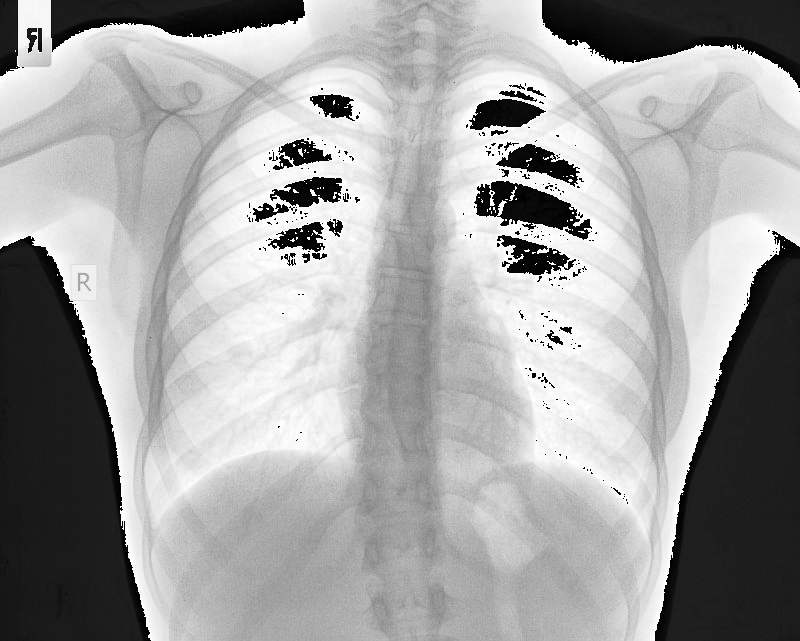

In [15]:
image_1_edited = adjust_gamma(np.array(image_1*255,dtype=np.uint8),2.5)/255 + 0.122
cv2_imshow(np.array(image_1_edited*255,dtype=np.uint8))

If we were to hazard a guess, the needed transformation passes through a state that increases instead of decreasing distance and that's why it cannot be obtained from the Genetic Algorithm. As such, we will have to begin anew, using domain knowledge to create image_2 from image_1. First, we need to increase the contrast. As such, we employ histogram equalization. Second, the background makes it obvious that at one point, complementing is needed. Thirdly, the brightness is much different, so Gamma correction is employed. Finally, the target image is blury so we introduce Gaussian Blur. Just as a test, some Sobel filters are ran through the image (while this code is my own, some of the ideas are not).

409.72356737305194


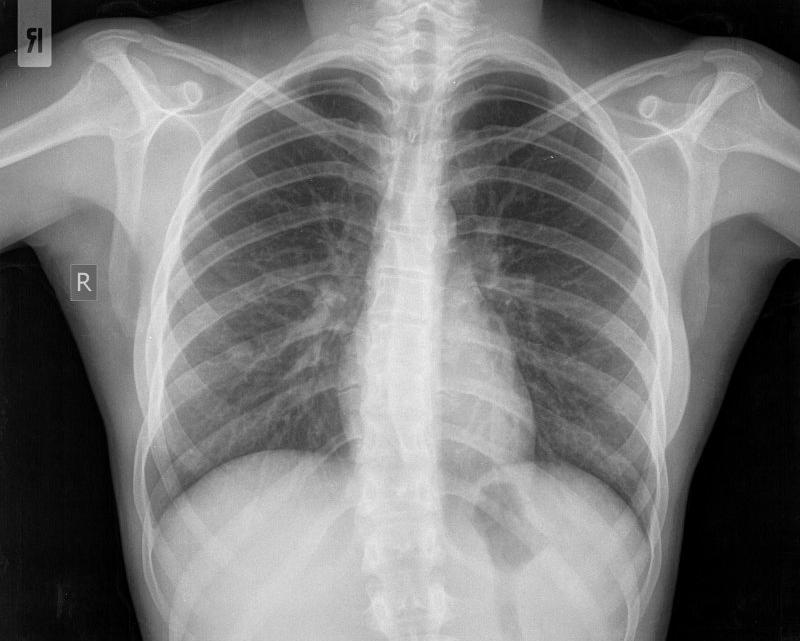

418.68816724594933


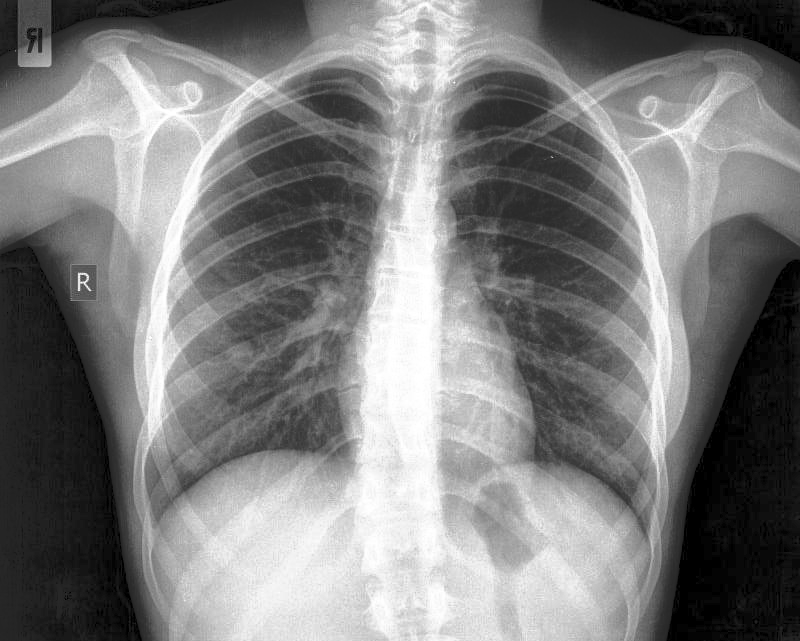

280.218654642838


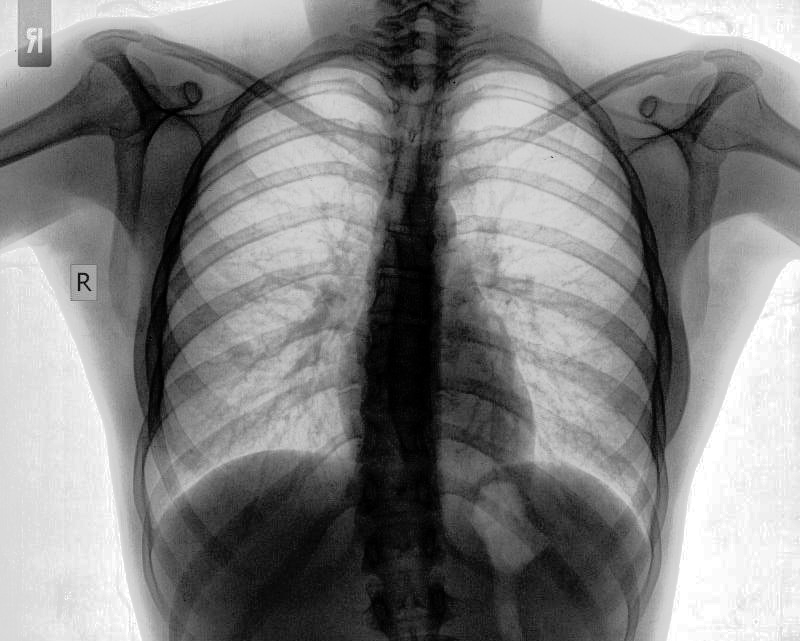

75.45535228457344


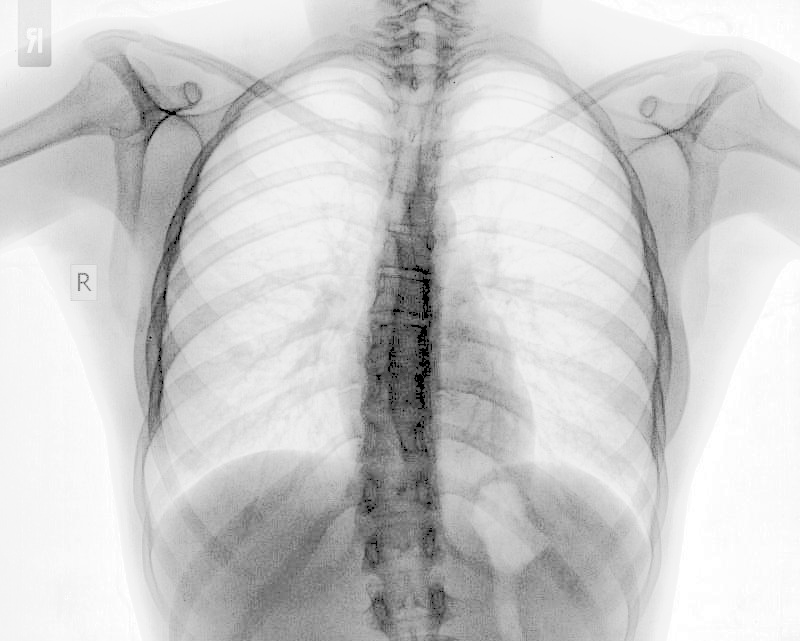

60.31170296718551


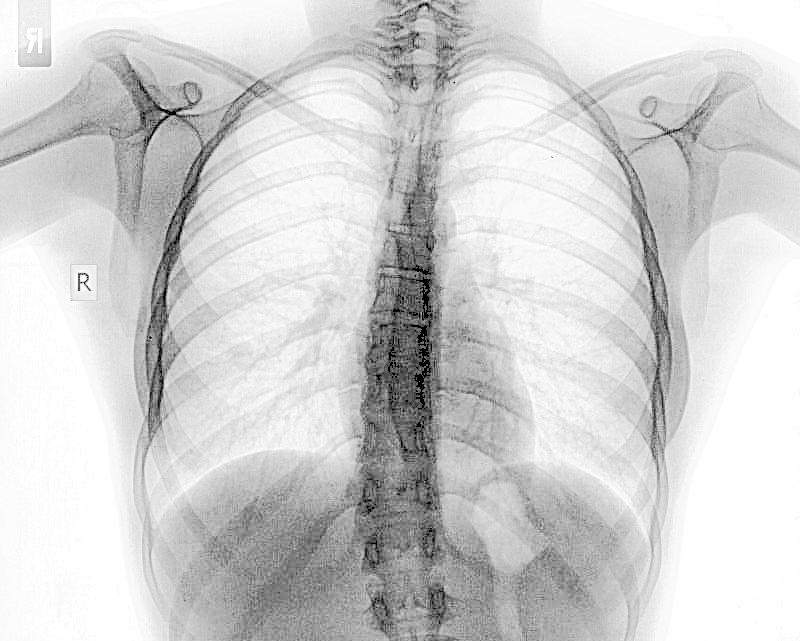

1964.1852458109952


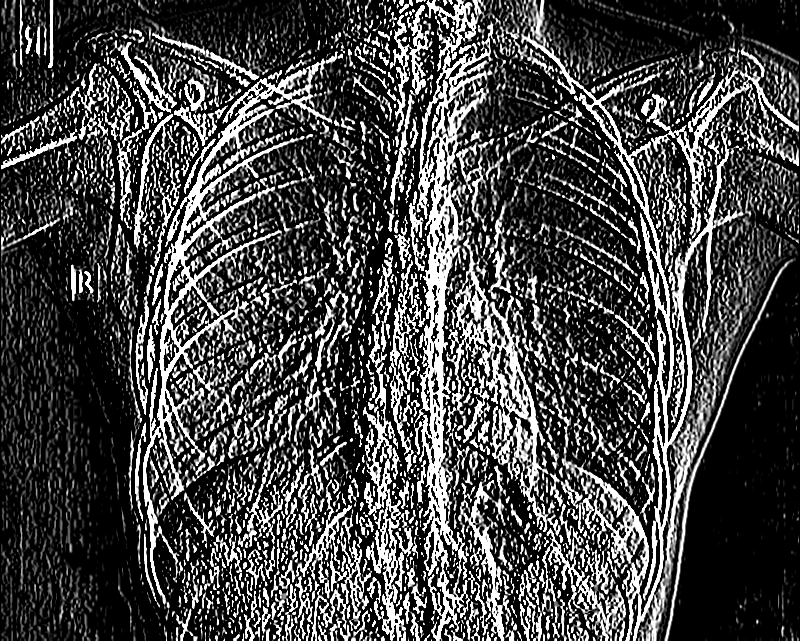

49108.1795216723


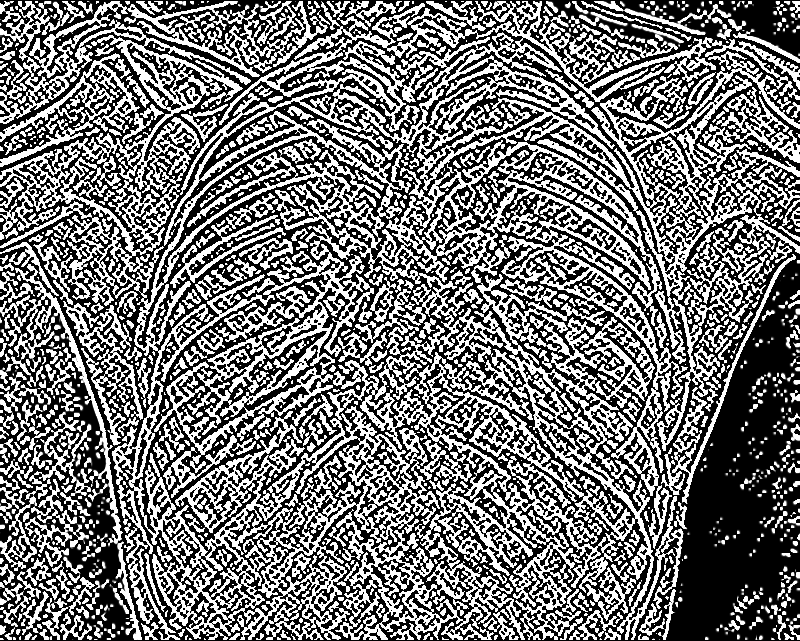

In [19]:
image_1 = cv2.imread("image_1.jpg",cv2.IMREAD_UNCHANGED) #Load it again
image_2 = cv2.imread("image_2.jpg",cv2.IMREAD_UNCHANGED)
print(np.linalg.norm(image_1/255 - image_2/255))
cv2_imshow(image_1)
image_1_1 = cv2.equalizeHist(image_1)
print(np.linalg.norm(image_1_1/255 - image_2/255))
cv2_imshow(image_1_1)
image_1_2 = 255 - image_1_1
print(np.linalg.norm(image_1_2/255 - image_2/255))
cv2_imshow(image_1_2)
image_1_3 = adjust_gamma(image_1_2,4,floating = False)
print(np.linalg.norm(image_1_3/255 - image_2/255))
cv2_imshow(image_1_3)
gaussian_4 = cv2.GaussianBlur(image_1_3, (9,9), 100) #apply the Gaussian Blur
image_1_4 = cv2.addWeighted(image_1_3, 1.9, gaussian_4, -0.9, 0, image_1_3) #Unsharpened image
print(np.linalg.norm(image_1_4/255 - image_2/255))
cv2_imshow(image_1_4)
image_1_5 = cv2.Sobel(image_1_4,cv2.CV_64F,1,0, ksize=5)
print(np.linalg.norm(image_1_5/255 - image_2/255))
cv2_imshow(image_1_5)
image_1_6 = cv2.Sobel(image_1_5,cv2.CV_64F,0,1,ksize = 5)
print(np.linalg.norm(image_1_6/255 - image_2/255))
cv2_imshow(image_1_6)

It seems that equalizing the histogram is a step that increases the distance and as such the elitist genetic algorithm will never pick it.

We've reached sufficient similarity with image_2.

Now let's see if the modifications used by the genetic algorithm can be applied in this case.

322.77357115962315


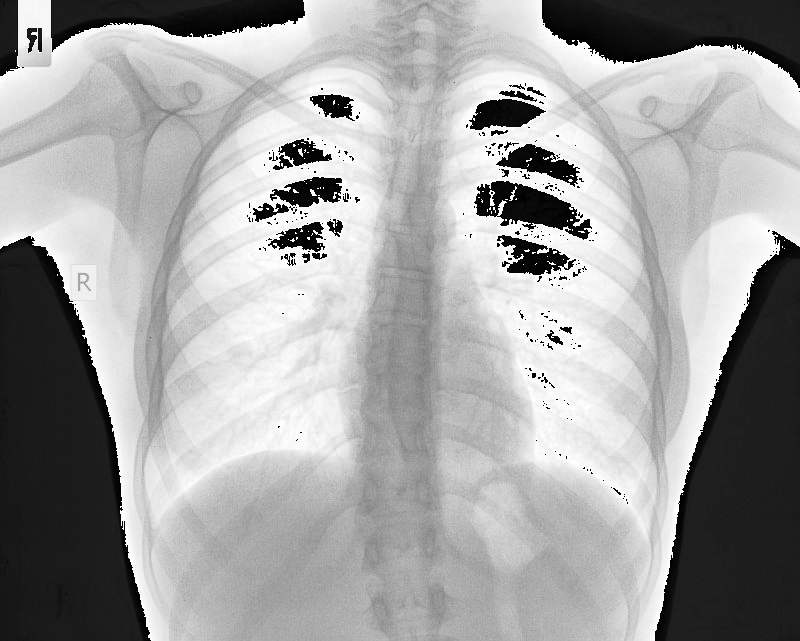

336.54597299857824


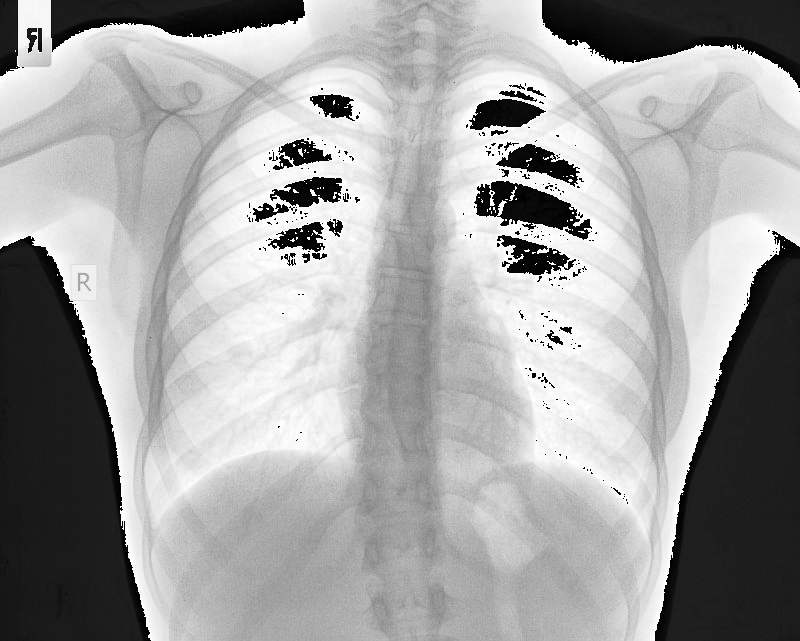

372.3124673973045


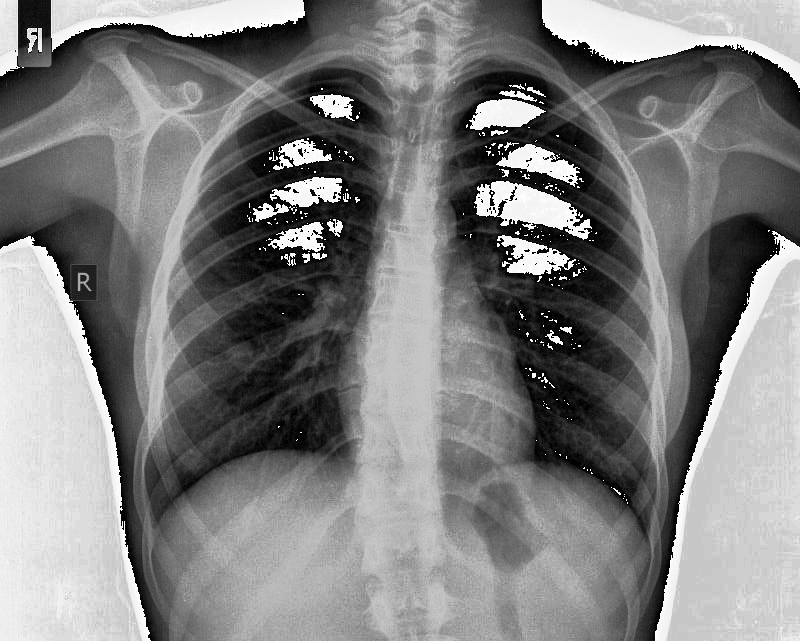

213.60016645852926


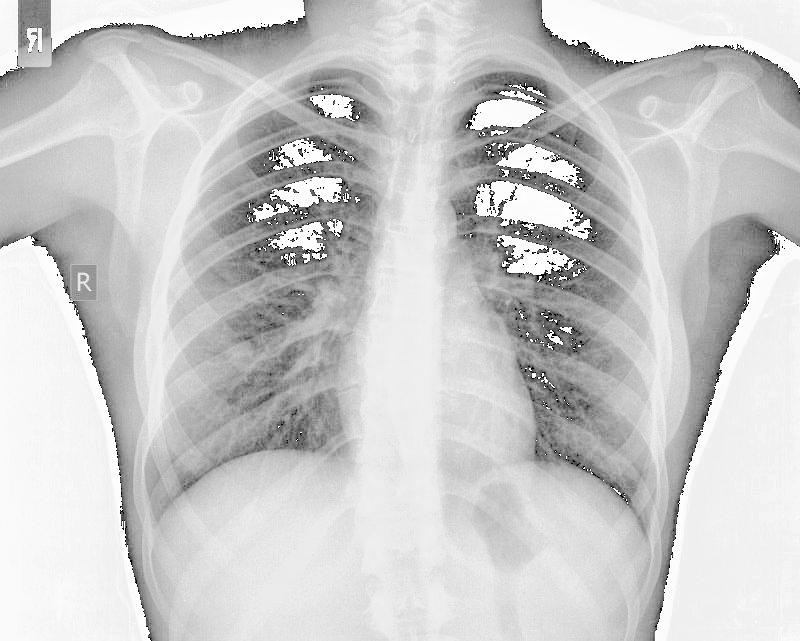

223.08506140326722


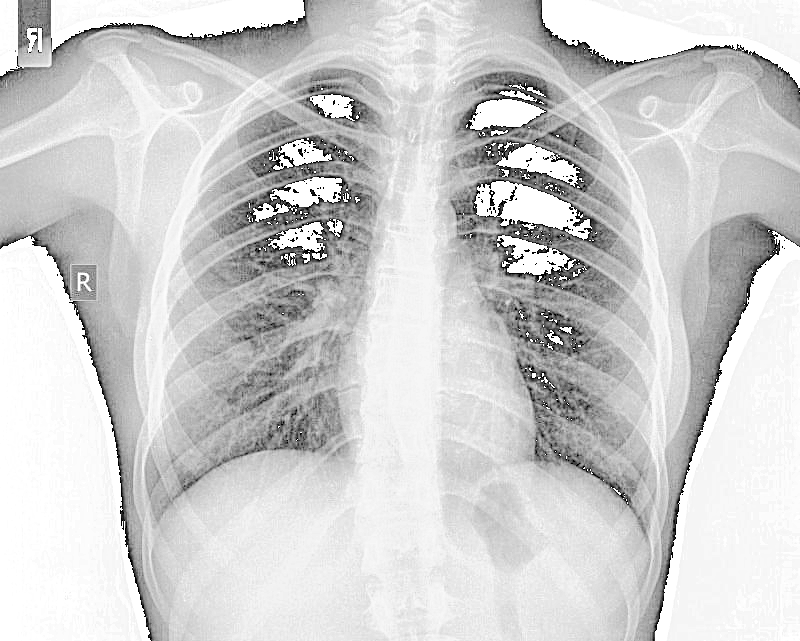

3099.0891800367485


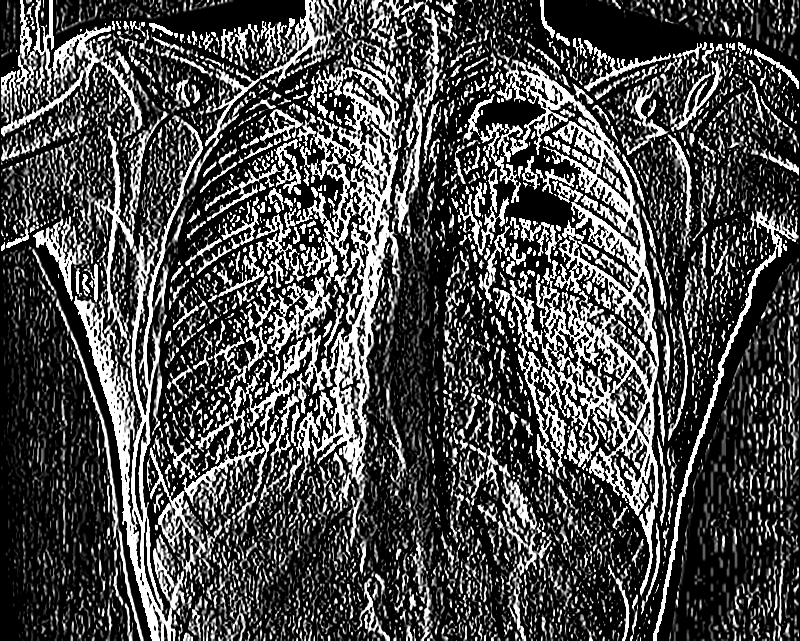

92699.57180875505


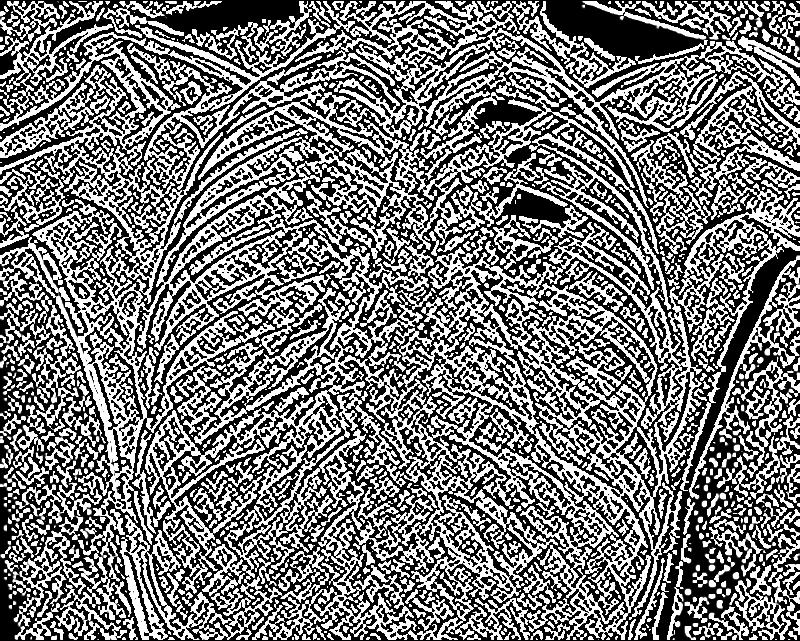

In [26]:
image_1 = cv2.imread("image_1.jpg",cv2.IMREAD_UNCHANGED) #Load it again
image_2 = cv2.imread("image_2.jpg",cv2.IMREAD_UNCHANGED)
image_1 = image_1/255
image_1_edited = adjust_gamma(np.array(image_1*255,dtype=np.uint8),2.5)/255 + 0.122
image_1_edited = np.array(image_1_edited*255,dtype=np.uint8)
print(np.linalg.norm(image_1_edited/255 - image_2/255))
cv2_imshow(image_1_edited)
image_1_edited_1 = cv2.equalizeHist(image_1_edited)
print(np.linalg.norm(image_1_edited_1/255 - image_2/255))
cv2_imshow(image_1_edited)
image_1_edited_2 = 255 - image_1_edited_1
print(np.linalg.norm(image_1_edited_2/255 - image_2/255))
cv2_imshow(image_1_edited_2)
image_1_edited_3 = adjust_gamma(image_1_edited_2,4,floating = False)
print(np.linalg.norm(image_1_edited_3/255 - image_2/255))
cv2_imshow(image_1_edited_3)
gaussian_4 = cv2.GaussianBlur(image_1_edited_3, (9,9), 100) #apply the Gaussian Blur
image_1_edited_4 = cv2.addWeighted(image_1_edited_3, 1.9, gaussian_4, -0.9, 0, image_1_edited_3) #Unsharpened image
print(np.linalg.norm(image_1_edited_4/255 - image_2/255))
cv2_imshow(image_1_edited_4)
image_1_edited_5 = cv2.Sobel(image_1_edited_4,cv2.CV_64F,1,0, ksize=5)
print(np.linalg.norm(image_1_edited_5/255 - image_2/255))
cv2_imshow(image_1_edited_5)
image_1_edited_6 = cv2.Sobel(image_1_edited_5,cv2.CV_64F,0,1,ksize = 5)
print(np.linalg.norm(image_1_edited_6/255 - image_2/255))
cv2_imshow(image_1_edited_6)

It seems the modifications are not compatible with each other. As such, the distance is larger, rather than smaller.

It seems that to go from image_1 to image_2, it suffices to apply the following transformations: equalize histogram, competent, gamma correction, unsharpening.

Next, we can try to reverse these steps to go from image_2 to image_1. As such, from image_2, we will take the competent, perform gamma correction and smooth it with a mean filter. Finally, we will attempt decreasing the contrast in orde to simulate the reverse of histogram equalization. A sharpening mask was used for this reason, but the result does not change significantly. Finally, using a kernel makes the image much worse.

409.72356737305194


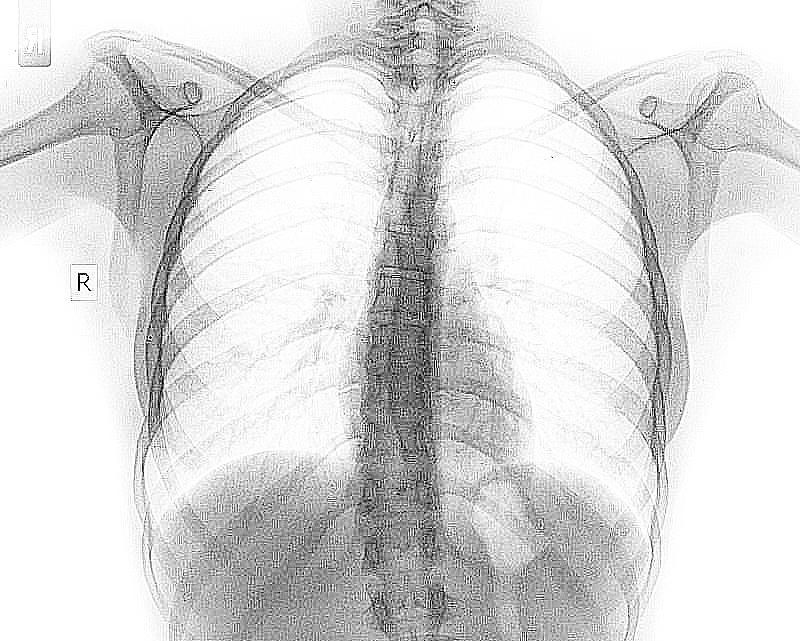

268.22066388836856


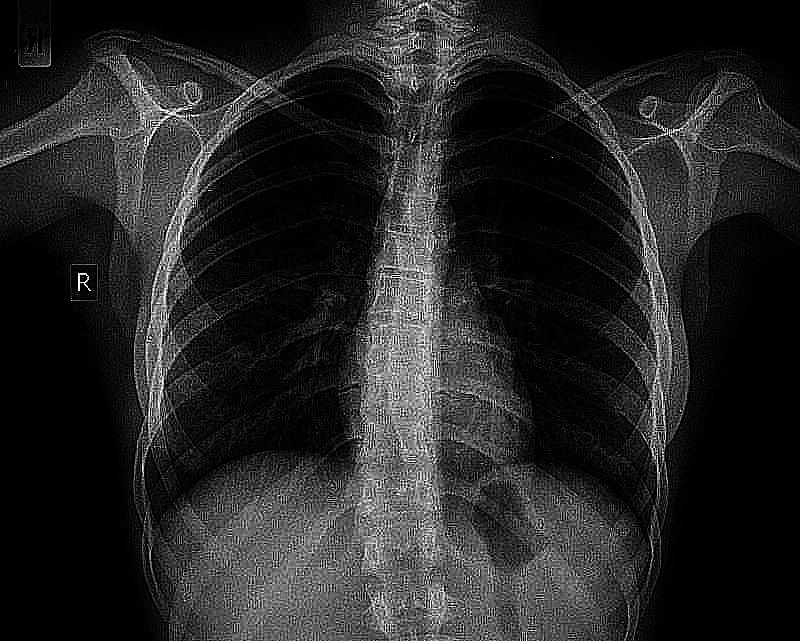

97.40348248710221


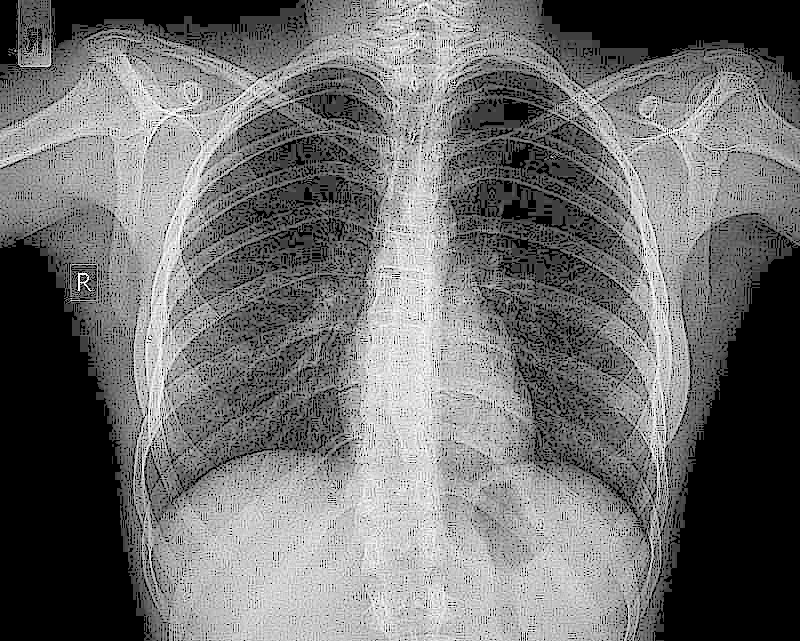

39.475804570421644


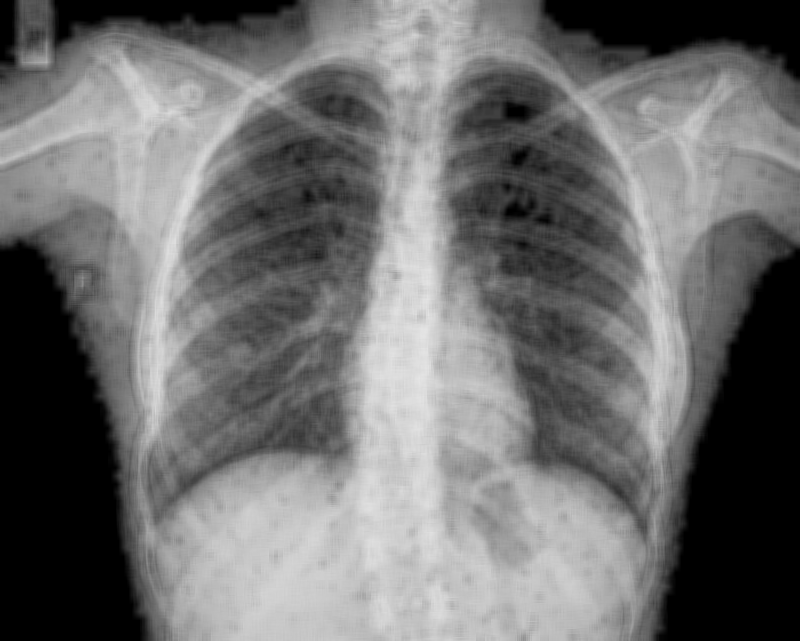

40.81172099470673


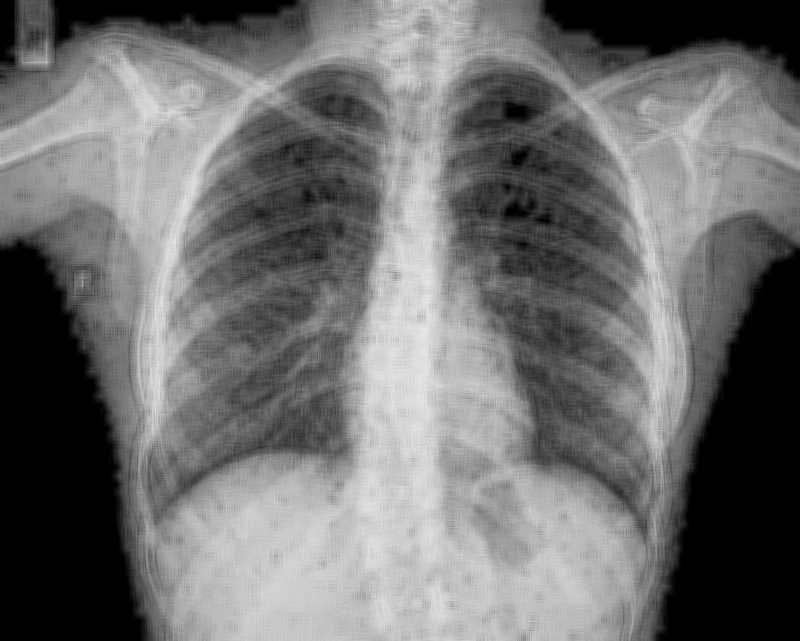

95.7714097314701


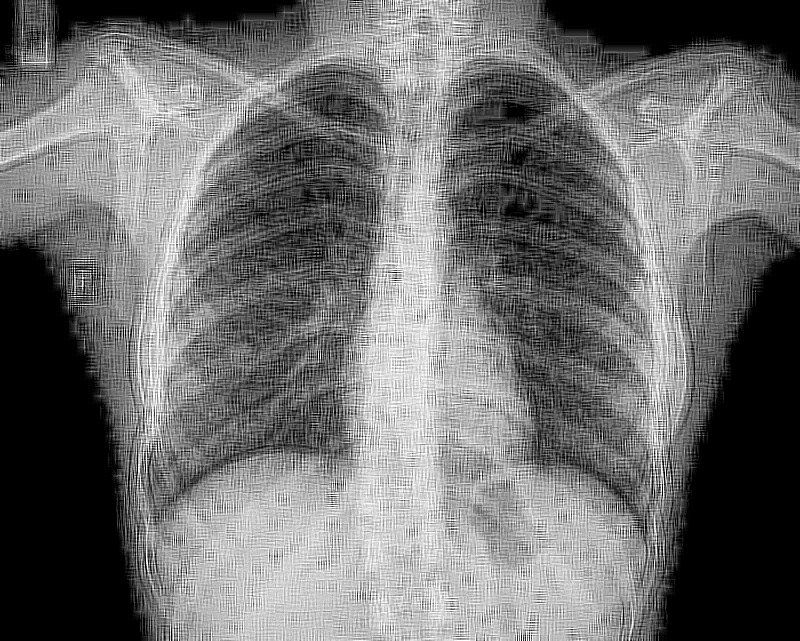

In [48]:
image_1 = cv2.imread("image_1.jpg",cv2.IMREAD_UNCHANGED) #Load it again
image_2 = cv2.imread("image_2.jpg",cv2.IMREAD_UNCHANGED)
print(np.linalg.norm(image_2/255 - image_1/255))
cv2_imshow(image_2)
image_2_1 = 255 - image_2
print(np.linalg.norm(image_2_1/255 - image_1/255))
cv2_imshow(image_2_1)
image_2_2 = adjust_gamma(image_2_1,4,floating = False)
print(np.linalg.norm(image_2_2/255 - image_1/255))
cv2_imshow(image_2_2)
image_2_3 = cv2.blur(image_2_2, (9,9)) #apply the Gaussian Blur
print(np.linalg.norm(image_2_3/255 - image_1/255))
cv2_imshow(image_2_3)
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred #Equivalent to add weighted
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened
image_2_4 = unsharp_mask(image_2_3,sigma=2, amount = 0.8,threshold=0.7)
print(np.linalg.norm(image_2_4/255 - image_1/255))
cv2_imshow(image_2_4)
kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
image_2_5 = cv2.filter2D(image_2_4, -1, kernel)
print(np.linalg.norm(image_2_5/255 - image_1/255))
cv2_imshow(image_2_5)